<a href="https://colab.research.google.com/github/TahiriNadia/CNNTrees/blob/master/3D_representations_on_simulated_rf_matrices_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Start

In [1]:
import os
import numpy  as np
import urllib.request as url
from array import *
import random
import tensorflow as tf
# tf.compat.v1.disable_eager_execution()

### Small simulated dataset

In [2]:
# b'20',    b'8',     b'1',       b'0',           b'0'
# nb_arbre, nb_taxon, nb_cluster, percent_noise, nb_eloignement
def mask_cluster (nb_cluster):
    cluster = np.zeros((1,NB_CLUSTERS))
    cluster[0,nb_cluster-1]=1
    return cluster

NB_CLUSTERS=5
NB_DEPTH=5808
NB_N=20

values_i = np.zeros((NB_DEPTH,NB_N,NB_N))
cluster_i = np.zeros((NB_DEPTH,NB_CLUSTERS))
nb_eloignements = np.zeros((NB_DEPTH))
cluster_ii = np.zeros((NB_DEPTH,NB_N,NB_CLUSTERS))

fh = url.urlopen( "https://github.com/TahiriNadia/ML_DL_Classification_Trees/raw/master/data/simulation/simulation_dataset")
depth = 0
l_i = 1

while True:
    ligne = fh.readline()
    nb_arbre,nb_taxon,nb_cluster,percent_noise,nb_eloignement = ligne.split()
    cluster_i[depth]=mask_cluster(int(nb_cluster))
    # cluster_ii[depth]=mask_cluster2(int(nb_cluster), int(nb_arbre))
    nb_eloignements[depth]=nb_eloignement
    for i in range(0, int(nb_arbre)):
        ligne = fh.readline()
        values_i [depth,i,:] = ligne.split()

    ligne = fh.readline()
    depth = depth + 1
    l_i = l_i + int(nb_arbre) + 2
    if not ligne:
      break
fh.close


<bound method HTTPResponse.close of <http.client.HTTPResponse object at 0x7f88f381bc10>>

In [3]:
def ConditionedSamples(x_values,y_values):
  nonzero = np.squeeze(np.sum(x_values,axis=(1,2))!=0) # indexes of zero matrices
  remoteness_down = (nb_eloignements >= 25)
  remoteness_up = (nb_eloignements < 75)
  remoteness = remoteness_down & remoteness_up
  # only_four = (y_values[:,4]==0)

  Conditioned_Index = nonzero & remoteness #& only_four
  X, y, remotenesses = x_values[Conditioned_Index], y_values[Conditioned_Index], nb_eloignements[Conditioned_Index]
  return X,y, Conditioned_Index

X, y, Conditioned_Index= ConditionedSamples(values_i,cluster_i)


In [4]:
y.shape

(2475, 5)

In [5]:
import plotly.graph_objs as go

NBins=6 # number "m" in article
Density =10

shape_6D = tf.cast(tf.repeat(Density, NBins),tf.int32)
shape_3D = tf.cast(tf.repeat(Density*Density, NBins//2),tf.int64)
Value_Range=tf.constant([0.,1.],dtype=tf.float32)

@tf.function(experimental_relax_shapes=True)
def tf_normalize(tensor):
  tensor=tf.cast(tensor,tf.float32)
  min = tf.reduce_min(tensor)
  return tf.divide( 
      tf.subtract(tensor, min), 
      tf.add(tf.subtract(tf.reduce_max(tensor), min),tf.constant(1e-25,dtype=tf.float32))
      )
  
@tf.function(experimental_relax_shapes=True)
def to_3DCube(rf_matrix, claster_num=-1): 
  #length - number "n" in article

  length = rf_matrix.shape[0]
  
  updates=tf.ones(length)
  
  @tf.function(experimental_relax_shapes=True)
  def dens(row):
    res = tf.cast(
        tf.histogram_fixed_width(values=tf_normalize(row), value_range=Value_Range, nbins=NBins)/length*Density
        , tf.int32)
    return res

  coords = tf.vectorized_map(dens, rf_matrix)

  cube=tf.scatter_nd(coords,updates, shape_6D )#[10,10,10,10,10,10]
  flatten_cube = tf.reshape(cube,shape_3D)
  sparse_cube = tf.sparse.from_dense(flatten_cube)
  return (sparse_cube.indices, tf.expand_dims(tf.cast(sparse_cube.values,dtype = tf.int8), 1), claster_num)


In [6]:
from sklearn.model_selection import train_test_split
test_size = 0.1
train_x,test_x, train_y, test_y = train_test_split(X,y,test_size=test_size)

In [19]:

import warnings
warnings.filterwarnings("ignore")

Batch_size=32

ds = tf.data.Dataset.from_tensor_slices((X,y))
ds = ds.map(to_3DCube)
cubes = ds.map(lambda ind,val,l:[tf.SparseTensor(ind,tf.squeeze(val),shape_3D),l])
cubes= cubes.map(lambda c,l:[tf.expand_dims(tf.sparse.to_dense(c,default_value=0,validate_indices=False), axis=-1),l])

length = X.shape[0]
split = int(length*(1.-test_size))
train_cubes=cubes.take(split).shuffle(1024).batch(Batch_size)
val_cubes = cubes.skip(split).shuffle(1024).batch(Batch_size)

steps_per_epoch=split//Batch_size
validation_steps = int(length - split)//Batch_size



In [20]:
ds.element_spec

(TensorSpec(shape=(None, 3), dtype=tf.int64, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.int8, name=None),
 TensorSpec(shape=(5,), dtype=tf.float64, name=None))

## 3D Cubes

since float 64 waste lot of memory for every representation I normalize the data to int8 for memory economy 



we will describe that all in the paper


In [9]:
train_cubes.element_spec

(TensorSpec(shape=(None, 100, 100, 100, 1), dtype=tf.int8, name=None),
 TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))

### Visualization

In [10]:
k=7
vectors = to_3DCube(X[k])


def pprint_sparse_tensor(st):
  s = "<SparseTensor shape=%s \n values={" % (st.dense_shape.numpy().tolist(),)
  for (index, value) in zip(st.indices, st.values):
    s += f"\n  %s: %s" % (index.numpy().tolist(), value.numpy().tolist())
  return s + "}>"

# sparse_cube= tf.sparse.from_dense(cube)

markers=dict(
    size= 3*np.squeeze(vectors[1]),
    opacity=0.8
    )
cluster_num = np.argmax(y[k])+1
fig = go.Figure(data=[go.Scatter3d(
      mode='markers',
      x=vectors[0][:,0],
      y=vectors[0][:,1],
      z=vectors[0][:,2], 
      showlegend=True , # labelled_components[:,3]
      marker=markers
      )]
      )
  # tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
print(F'Clasters: { cluster_num}, points: {vectors[0].shape[0]}')
fig.show()

Clasters: 2, points: 12


## CNN Model

we used 3D cubes 100x100x100


In [21]:
train_cubes

<BatchDataset shapes: ((None, 100, 100, 100, 1), (None, 5)), types: (tf.int8, tf.float64)>

In [22]:
# import tensorflow.keras.backend as K
# K.set_floatx('float32')
# K.set_epsilon(1e-4) #default is 1e-7

model_2=tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=train_cubes.element_spec[0].shape[1:]),
  tf.keras.layers.Conv3D(filters=128, kernel_size=10,strides=2, activation='relu', name='conv3d_0',),
  tf.keras.layers.MaxPool3D(10,strides=2),
  tf.keras.layers.Conv3D(filters=64, kernel_size=2, activation='relu', name='conv3d_1'),
  tf.keras.layers.MaxPool3D(2),
    tf.keras.layers.Conv3D(filters=32, kernel_size=2, activation='relu', name='conv3d_2'),
  tf.keras.layers.MaxPool3D(2),
  tf.keras.layers.Conv3D(filters=16, kernel_size=2, activation='relu', name='conv3d_3'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(train_cubes.element_spec[1].shape[-1], activation='softmax', name='softmax')
])


In [23]:
optimizer = tf.keras.optimizers.Adamax(lr=1e-3)
model_2.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy']
              )


In [24]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_0 (Conv3D)           (None, 46, 46, 46, 128)   128128    
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 19, 19, 19, 128)  0         
 3D)                                                             
                                                                 
 conv3d_1 (Conv3D)           (None, 18, 18, 18, 64)    65600     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 9, 9, 9, 64)      0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 8, 8, 8, 32)       16416     
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 4, 4, 4, 32)     

In [25]:
# model_2.optimizer = optimizer
train_cubes = train_cubes.cache()
val_cubes=val_cubes.cache()

In [26]:
epochs=10
history=model_2.fit(train_cubes, validation_data =val_cubes,
                      epochs=epochs,
                      # steps_per_epoch=split//batch_size,
                      # validation_steps = int(length - split)//batch_size
                      )

Epoch 1/10
70/70 [==============================] - 169s 2s/step - loss: 1.0743 - accuracy: 0.5276 - val_loss: 0.3036 - val_accuracy: 0.9274
Epoch 2/10
70/70 [==============================] - 128s 2s/step - loss: 0.4529 - accuracy: 0.8532 - val_loss: 0.1054 - val_accuracy: 0.9798
Epoch 3/10
70/70 [==============================] - 128s 2s/step - loss: 0.2881 - accuracy: 0.9044 - val_loss: 0.0682 - val_accuracy: 0.9839
Epoch 4/10
70/70 [==============================] - 128s 2s/step - loss: 0.2071 - accuracy: 0.9322 - val_loss: 0.0392 - val_accuracy: 0.9879
Epoch 5/10
70/70 [==============================] - 128s 2s/step - loss: 0.1547 - accuracy: 0.9497 - val_loss: 0.0303 - val_accuracy: 0.9919
Epoch 6/10
70/70 [==============================] - 128s 2s/step - loss: 0.1108 - accuracy: 0.9650 - val_loss: 0.0220 - val_accuracy: 0.9960
Epoch 7/10
70/70 [==============================] - 128s 2s/step - loss: 0.0838 - accuracy: 0.9740 - val_loss: 0.0269 - val_accuracy: 0.9879
Epoch 8/10
70

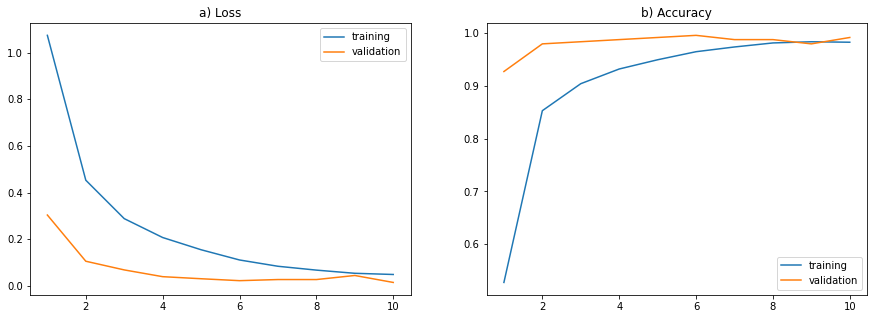

In [27]:
import matplotlib.pyplot as plt
 
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epoch_scale = range(1,len(loss)+1)
fig = plt.figure(figsize=(15,5))
ax=fig.add_subplot(1,2,1)
ax.set_title('a) Loss')
ax.plot(epoch_scale, loss)
ax.plot(epoch_scale, val_loss)
ax.legend(["training", "validation"])
# ax.axes.margins(0)
ax1=fig.add_subplot(1,2,2)
ax1.set_title('b) Accuracy')
ax1.plot(epoch_scale, accuracy)
ax1.plot(epoch_scale, val_accuracy)
ax1.legend(["training", "validation"])

fig.show()

In [28]:
initial_epoch=epochs
epochs=epochs+10
history=model_2.fit(train_cubes, validation_data =val_cubes,
                      epochs=epochs,
                      initial_epoch = initial_epoch,
                      # steps_per_epoch=split//batch_size,
                      # validation_steps = int(length - split)//batch_size
                      )

Epoch 11/20
70/70 [==============================] - 129s 2s/step - loss: 0.0406 - accuracy: 0.9861 - val_loss: 0.0230 - val_accuracy: 0.9919
Epoch 12/20
70/70 [==============================] - 128s 2s/step - loss: 0.0241 - accuracy: 0.9928 - val_loss: 0.0531 - val_accuracy: 0.9758
Epoch 13/20
70/70 [==============================] - 128s 2s/step - loss: 0.0164 - accuracy: 0.9973 - val_loss: 0.0184 - val_accuracy: 0.9960
Epoch 14/20
70/70 [==============================] - 128s 2s/step - loss: 0.0137 - accuracy: 0.9969 - val_loss: 0.0095 - val_accuracy: 0.9960
Epoch 15/20
70/70 [==============================] - 128s 2s/step - loss: 0.0211 - accuracy: 0.9933 - val_loss: 0.0126 - val_accuracy: 0.9960
Epoch 16/20
70/70 [==============================] - 128s 2s/step - loss: 0.0131 - accuracy: 0.9969 - val_loss: 0.0069 - val_accuracy: 0.9960
Epoch 17/20
70/70 [==============================] - 128s 2s/step - loss: 0.0193 - accuracy: 0.9919 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 

In [29]:
loss=[*loss, *history.history['loss']]
val_loss =[*val_loss, *history.history['val_loss']]
accuracy =[*accuracy, *history.history['accuracy']]
val_accuracy =[*val_accuracy, *history.history['val_accuracy']]
epoch_scale = range(1,len(loss)+1)


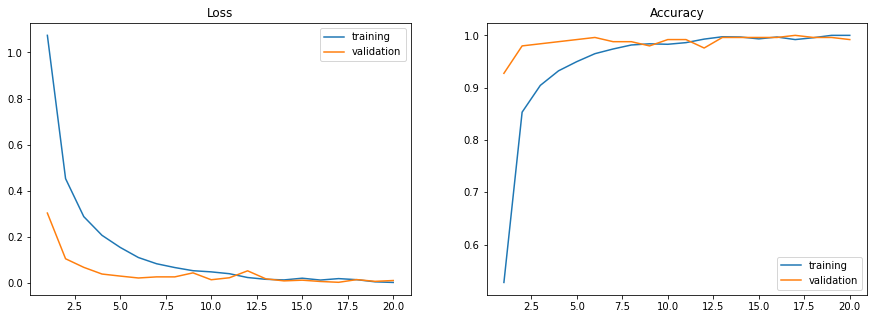

In [30]:

fig = plt.figure(figsize=(15,5))
ax=fig.add_subplot(1,2,1)
ax.set_title('Loss')
ax.plot(epoch_scale, loss)
ax.plot(epoch_scale, val_loss)
ax.legend(["training", "validation"])
# ax.axes.margins(0)
ax1=fig.add_subplot(1,2,2)
ax1.set_title('Accuracy')
ax1.plot(epoch_scale, accuracy)
ax1.plot(epoch_scale, val_accuracy)
ax1.legend(["training", "validation"])

fig.show()

for 20 epochs the same result is getting
so 10 epochs is enaugh

We got 98% accuracy for our 3D images of RF-Matrices, and these images is invariant to the number of trees in the matrices or order of entry of trees to the matrix eather

##Confusion matrix

In [31]:
validation_array = np.array(list(val_cubes.unbatch().as_numpy_iterator()),dtype=object)
test_x = np.stack(validation_array[:,0])
test_y = np.stack(validation_array[:,1])


In [32]:

# Use the model to predict the labels
test_predictions = model_2.predict(test_x,steps=test_x.shape[0])
test_y_pred = np.argmax(test_predictions, axis=1)
test_y_true = np.argmax(test_y, axis=1)

In [33]:
from sklearn.metrics import confusion_matrix
confMat=confusion_matrix( test_y_pred,test_y_true)
print( np.sum(np.diag(confMat))/len(test_y_true))

0.9919354838709677


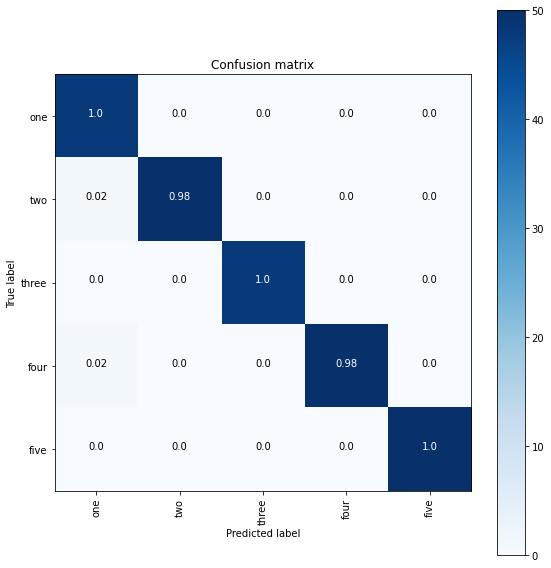

In [34]:
import itertools
import io
from tensorflow.image import decode_png

def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=90)
  plt.yticks(tick_marks, class_names)

  # Normalize the confusion matrix.
  cm = np.around(cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  # return figure

plot_confusion_matrix(confMat,class_names=('one','two','three','four','five'))